# Práctica 5. Detección de anomalías con autoencoder

En esta práctica vamos a ver un ejemplo práctico del uso de los autoencoders para la detección de anomalías. Como se ha explicado en este capítulo, los autoencoders son modelos generativos que se utilizan para la reconstrucción de datos de alta dimensionalidad usando dos redes: un encoder y un decoder.

El conjunto de datos que vamos a utilizar contiene información sobre fraude en tarjetas de crédito. Pertenece a una competición de *Kaggle* y es totalmente abierto y está anonimizado. Se puede descargar del siguiente [enlace](https://www.kaggle.com/mlg-ulb/creditcardfraud/download). Los datos corresponden a las transacciones realizadas durante dos días, en los que se produjeron 492 fraudes de entre 284.807 transacciones totales. Esta diferencia de frecuencias nos puede indicar que se puede plantear como un problema de detección de anomalías. El objetivo es detectar en qué casos las transacciones siguen un comportamiento normal y cuando se trata de fraude, es decir, cuando hay una anomalía.


## Importación de las librerías

A las librerías usuales añadimos `seaborn`, que nos resultará útil para hacer algunas representaciones gráficas.

In [1]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, roc_auc_score

In [2]:
## Opciones generales de Matplotlib para ajustar las figuras
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
## Este fragmento de código puede servir para solucionar algunos errores de CUDA
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass 

## Carga de los datos

In [4]:
df = pd.read_csv("data/creditcard.csv")
print("El conjunto de datos tiene {} filas y {} columnas.".format(*df.shape))
df.head()

El conjunto de datos tiene 284807 filas y 31 columnas.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Exploración de los datos

Por motivos de anonimato la mayoría de las variables proceden de realizar una PCA de los datos originales (`VX`). Las únicas variables que no se han transformado son `Time` (el tiempo transcurrido desde la primera transacción), `Amount` (la cantidad de la transacción) y `Class` (si es fraudulenta o no).

Lo primero que hacemos es comprobar que los tipos de las variables son los adecuados utilizando el método `.info()`:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Una vez hemos visto que todas parecen tener el tipo adecuado es recomendable comprobar que las etiquetas tienen los valores esperados. En este caso tenemos un problema binario, fraude/no fraude, por lo que esperamos que las etiquetas sean 1 (fraude) o 0 (no fraude). Lo comprobamos fácilmente con el método `.unique()`:

In [6]:
df.Class.unique()

array([0, 1], dtype=int64)

Aunque en este caso ya nos avisan de que es un problema desbalanceado, en general, también es recomendable observar la distribución de las etiquetas. Podemos utilizar el objeto `Counter()`:

In [7]:
Counter(df.Class)

Counter({0: 284315, 1: 492})

Comprobamos que se trata de un dataset muy desbalanceado: se tienen 284315 muestras de transacciones normales y 492 fraudulentas.

### Visualización de los datos

Antes de introducir los datos en nuestro modelo siempre es recomendable representar las distribuciones de cada variable para ver si es necesario realizar alguna transformación. También puede ser útil estudiar las correlaciones entre las variables para identificar posibles variables redundantes. En este caso, como sabemos que las características se han extraído de una PCA, podemos asumir que las variables se comportan correctamente y no están correlacionadas, y representar únicamente la variable `Amount`. Es necesario ajustar el rango de la representación porque la presencia de outliers evita que podamos ver nada si no lo hacemos.

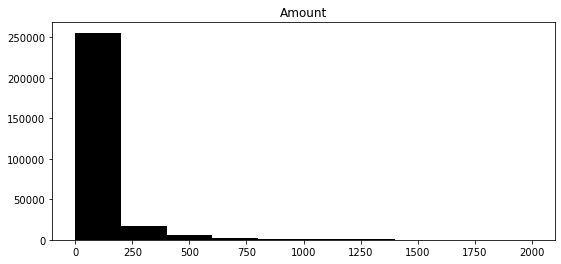

In [22]:
df.hist(column='Amount', range=[0,2000], grid=False, color='black')
# plt.savefig("Images/vis_amount.png")
plt.show()

Vemos que la mayoría de las transacciones que se realizan son de cantidades bajas. Este tipo de distribuciones pueden beneficiarse de algunas transformaciones para "normalizarlas" pero no prestaremos especial atención a eso en esta práctica.

Finalmente podemos representar la cantidad de las transacciones frente al porcentaje que representan del total. Esto nos puede situar en los rangos que podrían indicar que una transacción es fraudulenta o no:

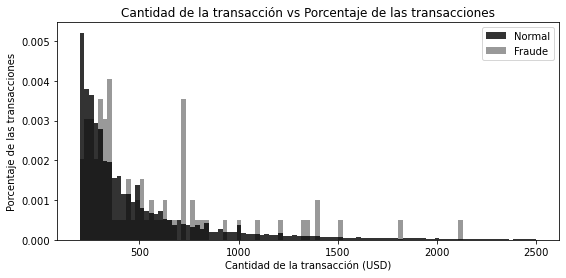

In [25]:
df_normal = df[df.Class == 0] 
df_fraud = df[df.Class == 1]
bins = np.linspace(200, 2500, 100)
plt.figure()
plt.hist(df_normal.Amount, bins=bins, alpha=0.8, 
         density=True, label='Normal', color='black')
plt.hist(df_fraud.Amount, bins=bins, alpha=0.4, 
          density=True, label='Fraude', color='black')
plt.legend(loc='upper right')
plt.title("Cantidad de la transacción vs Porcentaje de las transacciones")
plt.xlabel("Cantidad de la transacción (USD)")
plt.ylabel("Porcentaje de las transacciones")
# plt.savefig("Images/transacciones.png")
plt.show()

A partir de esta figura vemos que sí que existen más transacciones fraudulentas de mayor importe.

### Preparación de los datos

En los problemas de detección de anomalías, lo normal es entrenar los autoencoders **únicamente** con los datos normales. De esta forma, como el modelo aprende a reconstruirlos, si intenta reconstruir un dato que no ha visto nunca (anómalo), debería hacerlo considerablemente mal y podríamos detectar la anomalía.

Esto quiere decir que primero vamos a dividir los datos en dos conjuntos: transacciones normales y fraudes (esto ya lo hemos hecho para la representación anterior). Después dividiremos cada conjunto en entrenamiento, validación y test. De esta forma tendremos los seis conjuntos separados correctamente.

In [11]:
train_normal, test_normal = train_test_split(df_normal.drop(labels=["Time", "Class"], axis=1), 
                                             test_size=0.3)
val_normal, test_normal = train_test_split(test_normal, test_size=0.3)

train_fraud, test_fraud = train_test_split(df_fraud.drop(labels=["Time", "Class"], axis=1), 
                                           test_size=0.3)
val_fraud, test_fraud = train_test_split(test_fraud, test_size=0.3)

assert len(train_normal) + len(val_normal) + len(test_normal) == len(df_normal)
assert len(train_fraud) + len(val_fraud) + len(test_fraud) == len(df_fraud)

train = np.concatenate([train_normal, train_fraud])
val = np.concatenate([val_normal, val_fraud])
test = np.concatenate([test_normal, test_fraud])

Ahora podemos utilizar los datos del conjunto de entrenamiento para estandarizar el resto de datos. Es muy importante que solo utilicemos los datos de entrenamiento para estimar los parámetros de la estandarización, porque si no estaríamos filtrando información del resto de conjuntos al de entrenamiento y podríamos obtener resultados que no representasen la realidad. **Recordamos que solo es necesario que transformemos la variable `Amount`.**

El objeto `StandardScaler()` de `sklearn` facilita mucho este proceso:

In [57]:
# scaler = StandardScaler()
# scaler.fit(train[:,-1].reshape(1,-1))

In [12]:
scaler = StandardScaler()
scaler.fit(train)

train_normal_std, train_fraud_std = scaler.transform(train_normal), scaler.transform(train_fraud)
val_normal_std, val_fraud_std = scaler.transform(val_normal), scaler.transform(val_fraud)
test_normal_std, test_fraud_std = scaler.transform(test_normal), scaler.transform(test_fraud)

## Definición del modelo

Un autoencoder se caracteriza por tener una arquitectura que comprime los datos y luego los descomprime de forma simétrica. Esto quiere decir que tendremos que colocar capas de forma que la cantidad de neuronas vaya decreciendo hasta cierto punto (hasta la dimensión latente que consideremos) para volver a recuperar su dimensión original de forma inversa. Como este tipo de modelos no tiene conexiones entre capas, podemos utilizar la API Secuencial para definirlo cómodamente.

Hay que recordar que en este caso la función de activación de la capa de salida tiene que ser una función ReLU, porque tiene que ser capaz de producir cualquier valor posible. Como función de coste utilizaremos el Error Cuadrático Medio (MSE en inglés), y utilizaremos el optimizador *Adam* como viene siendo habitual:

In [60]:
# # Definimos las capas para la entrada, el encoder y el decoder:
# # Capa de entrada
# input_layer = Input(shape=(input_dim, ))

# # Capas del encoder
# encoder = Dense(15, activation='relu')(input_layer)
# encoder_2 = Dropout(0.2)(encoder)
# encoder_2 = Dense(8, activation='relu')(encoder_2)
# encoder_3 = Dense(4, activation='relu')(encoder_2)


# # Capas del decoder
# decoder = Dense(4, activation='relu')(encoder_3)
# decoder_2 = Dropout(0.2)(encoder)
# decoder_2 = Dense(15, activation='relu')(decoder_2)
# decoder_3 = Dense(30, activation='sigmoid')(decoder_2)
# #       Autoencoder
# # --------------------------
# # "encoded" es la representación codificada de la entrada (cada vez más comprimida)
# encoded = encoder_3

# # "decoded" es la reconstrución de la entrada a partir de la entrada codificada
# decoded = decoder_3

# # Modelo que reconstruye una entrada
# autoencoder = Model(input_layer, decoded)

# # Visualizar arquitectura y dimensiones
# print(f"{'*'*65}\n\t\t\tAutoencoder\n{'*'*65}")
# autoencoder.summary()

In [13]:
model = tf.keras.models.Sequential([
    layers.Dense(15, activation='relu', input_shape=(train.shape[-1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(15, activation='relu'),
    layers.Dense(train.shape[-1], activation='linear')
])
model.summary()
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 15)                135       
_________________________________________________________________
dense_5 (Dense)              (None, 29)                464       
Total params: 1,253
Trainable params: 1,253
Non-trainable params: 0
______________________________________________________

A la hora de elegir el mejor modelo posible y aplicar *early stopping* podría tener sentido quedarnos con el que obtenga mayor error en los datos de fraude, pero esto no suele proporcionar demasiados buenos resultados. Lo normal es que el error en los dos tipos de muestras sea diferente pero vaya decreciendo durante el entrenamiento, por lo que si utilizamos el máximo error para parar el entrenamiento lo normal es que lo paremos después de un par de épocas. Lo que suele funcionar mejor es utilizar el conjunto de validación normal para evitar el sobre-ajuste.

**Ejercicio: Prueba a elegir el mejor modelo basándote en el máximo del error de reconstrucción del fraude. ¿Qué observas?**

In [14]:
## Definición de los callbacks
cb_earlystopping = EarlyStopping(patience=8,
                                monitor='val_mae',
                                mode='min')
cb_modelcheckpoint = ModelCheckpoint(filepath='model_ae.h5',
                                     monitor='val_mae',
                                     mode='min',
                                     save_best_only=True)

## Entrenamiento del modelo
history = model.fit(train_normal_std,
                    train_normal_std,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_normal_std,val_normal_std),
                    callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/20
778/778 [==============================] - 6s 5ms/step - loss: 0.8651 - mae: 0.6139 - val_loss: 0.7844 - val_mae: 0.5859
Epoch 2/20
778/778 [==============================] - 3s 4ms/step - loss: 0.7653 - mae: 0.5733 - val_loss: 0.7456 - val_mae: 0.5677
Epoch 3/20
778/778 [==============================] - 3s 4ms/step - loss: 0.7405 - mae: 0.5618 - val_loss: 0.7265 - val_mae: 0.5589
Epoch 4/20
778/778 [==============================] - 3s 4ms/step - loss: 0.7223 - mae: 0.5538 - val_loss: 0.7089 - val_mae: 0.5525
Epoch 5/20
778/778 [==============================] - 4s 5ms/step - loss: 0.7029 - mae: 0.5485 - val_loss: 0.6892 - val_mae: 0.5479
Epoch 6/20
778/778 [==============================] - 3s 4ms/step - loss: 0.6812 - mae: 0.5436 - val_loss: 0.6703 - val_mae: 0.5415
Epoch 7/20
778/778 [==============================] - 3s 4ms/step - loss: 0.6630 - mae: 0.5374 - val_loss: 0.6520 - val_mae: 0.5365
Epoch 8/20
778/778 [==============================] - 3s 4ms/step - loss: 0.

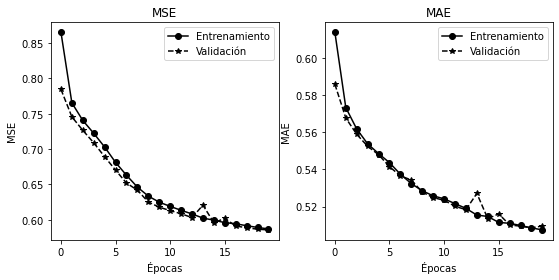

In [129]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'k-o', 
            label = "Entrenamiento")
plt.plot(history.history['val_loss'], 'k--*', 
            label = "Validación")
plt.ylabel('MSE')
plt.xlabel('Épocas')
plt.title('MSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.array(history.history['mae']), 'k-o', 
            label="Entrenamiento")
plt.plot(np.array(history.history['val_mae']), 'k--*', 
            label="Validación")
plt.ylabel('MAE')
plt.xlabel('Épocas')
plt.title('MAE')
plt.legend()
# plt.savefig("Images/train_ae.png")
plt.show()

Una vez hemos entrenado nuestro autoencoder podemos calcular los errores de reconstrucción de las muestras normales y las muestras de fraude:

In [86]:
def calculate_error(model, data):
    pred = model.predict(data)
    error = np.mean((pred-data)**2, axis=1)
    return error

In [88]:
error_train_normal = calculate_error(model, train_normal_std)
error_train_fraud = calculate_error(model, train_fraud_std)

Representando los histogramas de los dos errores podemos ver que, aunque hay valores de los dos conjuntos que se superponen, también hay errores mucho más grandes para los datos de fraude que para los datos normales. Esto es lo que buscábamos obtener.

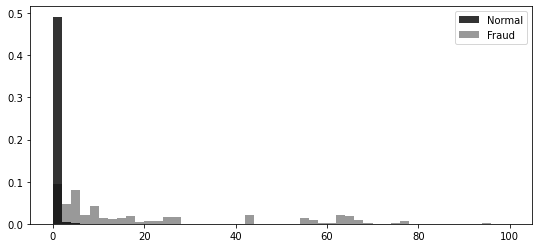

In [89]:
plt.figure()
plt.hist(error_train_normal, color='k', bins=50, alpha=0.8, label="Normal", range=[0,100], density=True)
plt.hist(error_train_fraud,  color='k', bins=50,  alpha=0.4, label="Fraud", range=[0,100], density=True)
plt.legend()
# plt.savefig("Images/hist_errores_train.png")
plt.show()

También podemos calcular la media de los errores normales y fraude:

In [90]:
error_train_normal.mean(), error_train_fraud.mean()

(0.5850001111764015, 19.26729352009007)

Vemos que hay una enorme diferencia entre los errores de reconstrucción de los dos tipos, por lo que parece que el modelo hace lo que esperábamos.

## Umbral: detectando anomalías

El problema que surge a continuación es cómo utilizar este error para detectar fraude. Una primera aproximación puede ser establecer un umbral y marcar como fraude las transacciones cuyo error de reconstrucción supere este umbral. No es una mala idea, pero tiene dos problemas:

- Si no tenemos suficientes datos, este umbral puede ser complicado de establecer. 

- Además, es otro hiperparámetro que puede sobreajustar nuestro conjunto de datos.

Basándonos en la figura anterior podemos considerar un umbral de 10 y comprobar lo que obtenemos. Como el conjunto de datos está muy desbalanceado lo que haremos será obtener la precisión, el recall y el F1-Score para medir el rendimiento del modelo. Cuando sea posible también calcularemos el área bajo la curva ROC.

**Ejercicio: En problemas desbalanceados como este el área bajo la curva ROC siempre es un buen estimador del rendimiento de los modelos. Intenta calcularla. ¿Qué problemas encuentras?**

Antes de poder calcular alguna métrica tenemos que volver a asociar las etiquetas correspondientes a las transacciones normales y fraude:

In [77]:
def rebuild_dataframe(error_normal, error_fraud):
    normal_labels = np.zeros(shape=(len(error_normal),))
    fraud_labels = np.ones(shape=(len(error_fraud),))
    labels = np.concatenate([normal_labels, fraud_labels])
    error = np.concatenate([error_normal, error_fraud])

    df_error = pd.DataFrame({'Error':error,
                             'Label':labels})

    return df_error   

In [93]:
error_val_normal = calculate_error(model, val_normal_std)
error_val_fraud = calculate_error(model, val_fraud_std)

error_test_normal = calculate_error(model, test_normal_std)
error_test_fraud = calculate_error(model, test_fraud_std)

In [94]:
df_error_train = rebuild_dataframe(error_train_normal, error_train_fraud)
df_error_val = rebuild_dataframe(error_val_normal, error_val_fraud)
df_error_test = rebuild_dataframe(error_test_normal, error_test_fraud)
df_error_train.head(1)

,Error,Label
0,0.390583,0.0


Y para calcular la predicción final solamente tenemos que umbralizar los errores:

In [51]:
def pred_threshold(error, threshold):
    return 1 if error > threshold else 0

In [95]:
df_error_train['Pred'] = df_error_train.Error.apply(pred_threshold, threshold=10)
df_error_val['Pred'] = df_error_val.Error.apply(pred_threshold, threshold=10)
df_error_test['Pred'] = df_error_test.Error.apply(pred_threshold, threshold=10)
df_error_train.head(1)

,Error,Label,Pred
0,0.390583,0.0,0


Finalmente calculamos las métricas:

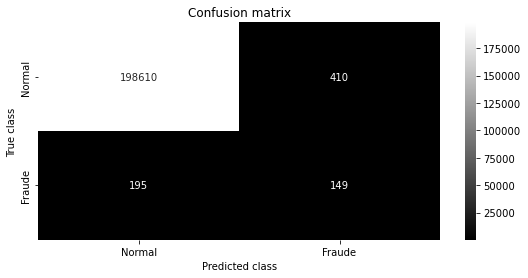

In [67]:
conf_matrix = confusion_matrix(df_error_train.Label, df_error_train.Pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'], annot=True, fmt="d", cmap='gray')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig("Images/cm_train_umbral.png")
plt.show()

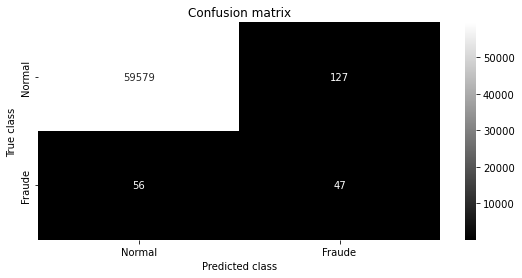

In [113]:
conf_matrix = confusion_matrix(df_error_val.Label, df_error_val.Pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'], annot=True, fmt="d", cmap='gray')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig("Images/cm_val_umbral.png")
plt.show()

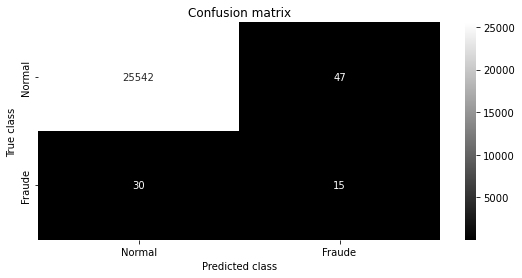

In [114]:
conf_matrix = confusion_matrix(df_error_test.Label, df_error_test.Pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'], annot=True, fmt="d", cmap='gray')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig("Images/cm_test_umbral.png")
plt.show()

In [130]:
def evaluate_model(y_true, y_pred, verbose=True):
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)

    if verbose:
        print("Accuracy: ", acc)
        print("Recall: ", recall)
        print("Precision: ", precision)
        print("F1: ", f1)

    return acc, recall, precision, f1

In [131]:
print("[Train]")
metrics_threshold_train = evaluate_model(df_error_train.Label, df_error_train.Pred)

[Train]
Accuracy:  0.9969653498124035
Recall:  0.4331395348837209
Precision:  0.26654740608228983
F1:  0.3300110741971208


In [132]:
print("[Validation]")
metrics_threshld_val = evaluate_model(df_error_val.Label, df_error_val.Pred)

[Validation]
Accuracy:  0.9969402598271163
Recall:  0.4563106796116505
Precision:  0.27011494252873564
F1:  0.33935018050541516


In [133]:
print("[Test]")
metrics_threshld_test = evaluate_model(df_error_test.Label, df_error_test.Pred)

[Test]
Accuracy:  0.996996176952485
Recall:  0.3333333333333333
Precision:  0.24193548387096775
F1:  0.28037383177570097


### Utilizando otro modelo como umbral

Ya hemos visto los inconvenientes que tiene el método del umbral. Si queremos ir un paso más allá, podemos entrenar otro modelo que nos prediga la clase de la transacción a partir del error de reconstrucción. De esta forma evitamos tener que establecerlo a mano. En general es complicado que un modelo sea capaz de extraer mucha información a partir de una única característica (el error), así que lo que haremos será obtener un nuevo dataframe que contenga el error de reconstrucción de cada característica en lugar del error medio de la muestra entera y utilizarlo como entradas de nuestro modelo.

**Ejercicio: No es necesario que este modelo sea un modelo neuronal. Prueba también con otros modelos no neuronales como Random Forest y compara el resultado.**

In [195]:
def calculate_error_2(model, data):
    pred = model.predict(data)
    error = (pred-data)**2
    return error

In [203]:
error_train_normal_2 = calculate_error_2(model, train_normal_std)
error_train_fraud_2 = calculate_error_2(model, train_fraud_std)

error_val_normal_2 = calculate_error_2(model, val_normal_std)
error_val_fraud_2 = calculate_error_2(model, val_fraud_std)

error_test_normal_2 = calculate_error_2(model, test_normal_std)
error_test_fraud_2 = calculate_error_2(model, test_fraud_std)

error_train_2 = np.concatenate([error_train_normal_2, error_train_fraud_2])
error_val_2 = np.concatenate([error_val_normal_2, error_val_fraud_2])
error_test_2 = np.concatenate([error_test_normal_2, error_test_fraud_2])

In [206]:
model_th = tf.keras.models.Sequential([
    layers.Dense(5, activation='relu', input_shape=(error_train_2.shape[1],)),
    layers.Dense(1, activation='sigmoid')
])
model_th.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC'])

In [207]:
## Definición de los callbacks
cb_earlystopping = EarlyStopping(patience=4,
                                monitor='val_auc',
                                mode='max')
cb_modelcheckpoint = ModelCheckpoint(filepath='model_ae_th_2.h5',
                                     monitor='val_auc',
                                     mode='max',
                                     save_best_only=True)

history_th = model_th.fit(error_train_2, 
                        df_error_train.Label,
                        epochs=10, batch_size=256,
                        validation_data=(error_val_2, df_error_val.Label),
                        callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/10
779/779 [==============================] - 5s 5ms/step - loss: 0.1439 - accuracy: 0.9974 - auc: 0.3522 - val_loss: 0.0262 - val_accuracy: 0.9983 - val_auc: 0.7784
Epoch 2/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0157 - accuracy: 0.9983 - auc: 0.8278 - val_loss: 0.0166 - val_accuracy: 0.9983 - val_auc: 0.8683
Epoch 3/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0112 - accuracy: 0.9987 - auc: 0.8620 - val_loss: 0.0142 - val_accuracy: 0.9990 - val_auc: 0.8946
Epoch 4/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0090 - accuracy: 0.9990 - auc: 0.8932 - val_loss: 0.0121 - val_accuracy: 0.9992 - val_auc: 0.8951
Epoch 5/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0075 - accuracy: 0.9991 - auc: 0.8951 - val_loss: 0.0105 - val_accuracy: 0.9991 - val_auc: 0.9028
Epoch 6/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0063 - accuracy: 0.9991 - auc: 0.8981 - val_loss: 0.00

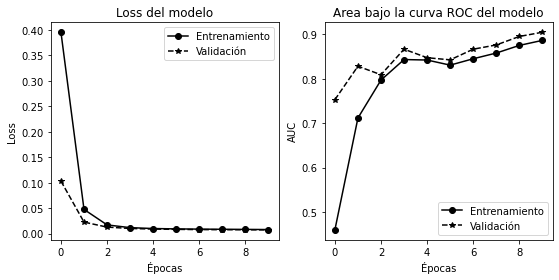

In [214]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(history_th.history['loss'], 'k-o', 
            label = "Entrenamiento")
plt.plot(history_th.history['val_loss'], 'k--*', 
            label = "Validación")
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.title('Loss del modelo')
plt.legend()

# plt.subplot(1,3,2)
# plt.plot(np.array(history_2.history['accuracy'])*100, 'k-o', 
#             label="Entrenamiento")
# plt.plot(np.array(history_2.history['val_accuracy'])*100, 'k--*', 
#             label="Validación")
# plt.ylabel('% Tasa de acierto')
# plt.xlabel('Épocas')
# plt.title('Tasa de acierto del modelo')
# plt.legend()

plt.subplot(1,2,2)
plt.plot(np.array(history_th.history['auc']), 'k-o', 
            label="Entrenamiento")
plt.plot(np.array(history_th.history['val_auc']), 'k--*', 
            label="Validación")
plt.ylabel('AUC')
plt.xlabel('Épocas')
plt.title('Area bajo la curva ROC del modelo')
plt.legend()
# plt.savefig("Images/train_threshold_nn_2.png")
plt.show()

Y comprobamos si mejoran o no los resultados:

**Ejercicio: Ahora sí que podemos calcular el AUC. ¿Por qué?**

In [ ]:
def evaluate_model(model, x, y_true, verbose=True):
    y_score = model.predict(x)
    y_pred = np.where(y_score>0.5, 1, 0)
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    auc = roc_auc_score(y_true, y_score)

    if verbose:
        print("Accuracy: ", acc)
        print("Recall: ", recall)
        print("Precision: ", precision)
        print("F1: ", f1)
        print("AUC: ", auc)

    return acc, recall, precision, f1, auc

No nos podemos olvidar de cargar los pesos del mejor modelo:

In [209]:
model_th.load_weights("model_ae_th_2.h5")

In [210]:
print("[Train]")
metrics_threshold_nn_train_2 = evaluate_model(model_th, 
                                              error_train_2, 
                                              df_error_train.Label)

[Train]
Accuracy:  0.9990218896089564
Recall:  0.5058139534883721
Precision:  0.8743718592964824
F1:  0.6408839779005525
AUC:  0.9169841452769735


In [211]:
print("[Validation]")
metrics_threshold_nn_val_2 = evaluate_model(model_th, 
                                            error_val_2, 
                                            df_error_val.Label)

[Validation]
Accuracy:  0.9991974452005551
Recall:  0.6213592233009708
Precision:  0.8767123287671232
F1:  0.7272727272727272
AUC:  0.9082010752362953


In [212]:
print("[Test]")
metrics_threshold_nn_test_2 = evaluate_model(model_th, 
                                             error_test_2, 
                                             df_error_test.Label)

[Train]
Accuracy:  0.9989467113989233
Recall:  0.4666666666666667
Precision:  0.875
F1:  0.608695652173913
AUC:  0.9054802193650917


**Ejercicio: Comprueba qué pasa si se utiliza únicamente el error como entrada al modelo. ¿Se obtiene lo mismo?**

In [187]:
model_2 = tf.keras.models.Sequential([
    layers.Dense(5, activation='relu', input_shape=(1,)),
    layers.Dense(1, activation='sigmoid')
])
model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC'])

In [188]:
## Definición de los callbacks
cb_earlystopping = EarlyStopping(patience=4,
                                monitor='val_auc',
                                mode='max')
cb_modelcheckpoint = ModelCheckpoint(filepath='model_ae_th.h5',
                                     monitor='val_auc',
                                     mode='max',
                                     save_best_only=True)

history_2 = model_2.fit(df_error_train.Error, 
                        df_error_train.Label,
                        epochs=10, batch_size=256,
                        validation_data=(val_2, df_error_val.Label),
                        callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/10
779/779 [==============================] - 5s 6ms/step - loss: 0.3954 - accuracy: 0.9626 - auc: 0.4593 - val_loss: 0.1031 - val_accuracy: 0.9982 - val_auc: 0.7529
Epoch 2/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0475 - accuracy: 0.9982 - auc: 0.7117 - val_loss: 0.0226 - val_accuracy: 0.9984 - val_auc: 0.8284
Epoch 3/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0171 - accuracy: 0.9983 - auc: 0.7972 - val_loss: 0.0127 - val_accuracy: 0.9983 - val_auc: 0.8092
Epoch 4/10
779/779 [==============================] - 4s 5ms/step - loss: 0.0117 - accuracy: 0.9983 - auc: 0.8435 - val_loss: 0.0101 - val_accuracy: 0.9982 - val_auc: 0.8668
Epoch 5/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0099 - accuracy: 0.9982 - auc: 0.8424 - val_loss: 0.0089 - val_accuracy: 0.9983 - val_auc: 0.8476
Epoch 6/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0092 - accuracy: 0.9983 - auc: 0.8309 - val_loss: 0.00

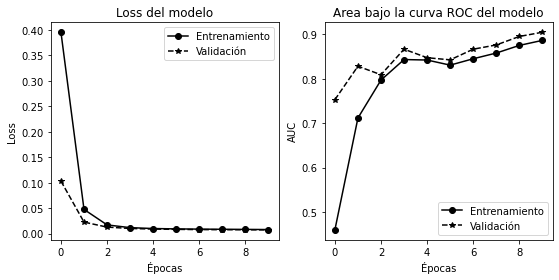

In [189]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(history_2.history['loss'], 'k-o', 
            label = "Entrenamiento")
plt.plot(history_2.history['val_loss'], 'k--*', 
            label = "Validación")
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.title('Loss del modelo')
plt.legend()

# plt.subplot(1,3,2)
# plt.plot(np.array(history_2.history['accuracy'])*100, 'k-o', 
#             label="Entrenamiento")
# plt.plot(np.array(history_2.history['val_accuracy'])*100, 'k--*', 
#             label="Validación")
# plt.ylabel('% Tasa de acierto')
# plt.xlabel('Épocas')
# plt.title('Tasa de acierto del modelo')
# plt.legend()

plt.subplot(1,2,2)
plt.plot(np.array(history_2.history['auc']), 'k-o', 
            label="Entrenamiento")
plt.plot(np.array(history_2.history['val_auc']), 'k--*', 
            label="Validación")
plt.ylabel('AUC')
plt.xlabel('Épocas')
plt.title('Area bajo la curva ROC del modelo')
plt.legend()
# plt.savefig("Images/train_threshold_nn.png")
plt.show()

In [191]:
model_2.load_weights("model_ae_th.h5")

In [192]:
print("[Train]")
metrics_threshold_nn_train = evaluate_model(model_2, 
                                            df_error_train.Error, 
                                            df_error_train.Label)

[Train]
Accuracy:  0.998043779217913
Recall:  0.21511627906976744
Precision:  0.38144329896907214
F1:  0.275092936802974
AUC:  0.9363217118531968


In [193]:
print("[Validation]")
metrics_threshold_nn_val = evaluate_model(model_2, 
                                          df_error_val.Error, 
                                          df_error_val.Label)

[Validation]
Accuracy:  0.9980103328930429
Recall:  0.2621359223300971
Precision:  0.38571428571428573
F1:  0.3121387283236994
AUC:  0.9435622901733056


In [194]:
print("[Train]")
metrics_threshold_nn_test = evaluate_model(model_2, 
                                           df_error_test.Error, 
                                           df_error_test.Label)

[Train]
Accuracy:  0.9981274869314192
Recall:  0.15555555555555556
Precision:  0.4117647058823529
F1:  0.22580645161290322
AUC:  0.9365708355586819


En general es complicado que un modelo sea capaz de extraer mucha información a partir de una única característica (el error). 

**Ejercicio: Obtén un nuevo dataframe que contenga el error de reconstrucción de cada característica en lugar del error medio de la muestra entera y comprueba si cambia el resultado.**